# Convolutional Neural Network

In [1]:
import numpy as np
import pandas as pd
from matplotlib import style 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from scipy import signal

style.use("ggplot")

%matplotlib inline

In [2]:
data_folder = "./data/shapes/"

shapes_classes = os.listdir(data_folder)
shapes_classes

['square', 'circle', 'triangle']

In [3]:
import tensorflow
from tensorflow import keras

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
image_size = (128,128)
batch_size = 30

datagen = ImageDataGenerator(rescale=1.0/255,validation_split=0.3)

In [6]:
training_generator = datagen.flow_from_directory(
    directory=data_folder,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

testing_generator = datagen.flow_from_directory(
    directory=data_folder,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 840 images belonging to 3 classes.
Found 360 images belonging to 3 classes.


In [7]:
class_labels = training_generator.class_indices.keys()

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    Dense,
    MaxPooling2D,
    Dropout,
    Flatten
)

In [9]:
model= Sequential()

## Convolution 


[Understanding Convolution](https://nishantbaheti.github.io/machineLearningExploration/MathExploration/Convolution.html#Understanding-Convolution)

In [10]:
# The input layer accepts an image and applies a convolution that uses 32 6x6 filters and a rectified linear unit activation function
model.add(
    Conv2D(
        filters=32, 
        kernel_size=(6, 6), 
        input_shape=training_generator.image_shape, 
        activation='relu'
    )
)

## Pooling

- After extracting feature values from images, pooling (or downsampling) layers are used to reduce the number of feature values while retaining the key differentiating features that have been extracted.
- The feature map extracted by a filter in a convolutional layer contains an array of feature values.
- A pooling kernel is used to reduce the number of feature values. In this case, the kernel size is 2x2, so it will produce an array with quarter the number of feature values.
- The pooling kernel is convolved across the feature map, retaining only the highest pixel value in each position.


        0   0   0                             155 255
        0  155 255  =>  apply 2X2 pooling =>  155 255
        155 0   0

In [11]:

# Next we'll add a max pooling layer with a 2x2 patch
model.add(
    MaxPooling2D(
        pool_size=(2,2)
    )
)

- We can add as many layers as we think necessary - here we'll add another convolution and max pooling layer

In [12]:
model.add(
    Conv2D(
        filters=32, 
        kernel_size=(6, 6), 
        activation='relu'
    )
)
model.add(
    MaxPooling2D(
        pool_size=(2, 2)
    )
)

# And another set
model.add(
    Conv2D(
        filters=32, 
        kernel_size=(6, 6), 
        activation='relu'
    )
)
model.add(
    MaxPooling2D(
        pool_size=(2, 2)
    )
)

## Dropping layer

One of the most difficult challenges in a CNN is the avoidance of overfitting, where the resulting model performs well with the training data but doesn't generalize well to new data on which it wasn't trained. One technique you can use to mitigate overfitting is to include layers in which the training process randomly eliminates (or "drops") feature maps. This may seem counterintuitive, but it's an effective way to ensure that the model doesn't learn to be over-dependent on the training images.

Other techniques you can use to mitigate overfitting include randomly flipping, mirroring, or skewing the training images to generate data that varies between training epochs.

In [13]:
# A dropout layer randomly drops some nodes to reduce inter-dependencies (which can cause over-fitting)
model.add(
    Dropout(0.2)
)

## Flattening layer

After using convolutional and pooling layers to extract the salient features in the images, the resulting feature maps are multidimensional arrays of pixel values. A flattening layer is used to flatten the feature maps into a vector of values that can be used as input to a fully connected layer.

In [14]:
# Flatten the feature maps 
model.add(Flatten())

## Generate a fully-connected output layer with a predicted probability for each class

In [15]:
# (softmax ensures all probabilities sum to 1)
model.add(
    Dense(
        training_generator.num_classes, 
        activation='softmax'
    )
)

# With the layers defined, we can now compile the model for categorical (multi-class) classification
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 123, 123, 32)      3488      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 32)        36896     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 32)        36896     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 32)        0

In [22]:
# Train the model over 5 epochs using 30-image batches and using the validation holdout dataset for validation
num_epochs = 5
history = model.fit(
    training_generator,
    steps_per_epoch = training_generator.samples // batch_size,
    validation_data = testing_generator, 
    validation_steps = testing_generator.samples // batch_size,
    epochs = num_epochs)

Epoch 1/5
28/28 [==============================] - 46s 2s/step - loss: 0.0142 - accuracy: 0.9940 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 2/5
28/28 [==============================] - 46s 2s/step - loss: 0.0106 - accuracy: 0.9964 - val_loss: 0.0374 - val_accuracy: 0.9806
Epoch 3/5
28/28 [==============================] - 41s 1s/step - loss: 0.0063 - accuracy: 0.9976 - val_loss: 2.7388e-04 - val_accuracy: 1.0000
Epoch 4/5
28/28 [==============================] - 42s 2s/step - loss: 1.0758e-04 - accuracy: 1.0000 - val_loss: 2.6620e-04 - val_accuracy: 1.0000
Epoch 5/5
28/28 [==============================] - 40s 1s/step - loss: 0.0010 - accuracy: 0.9988 - val_loss: 5.4982e-05 - val_accuracy: 1.0000


In [23]:
model_history = history.history

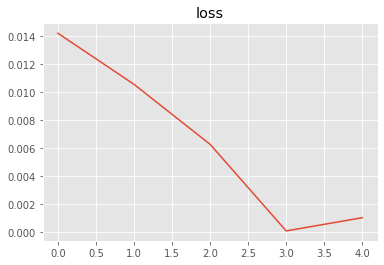

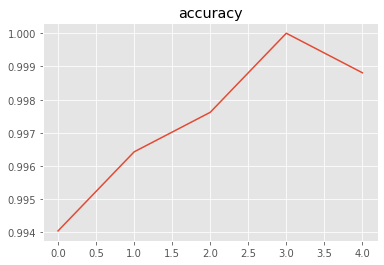

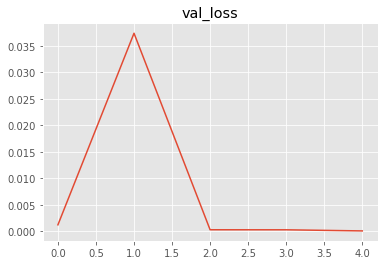

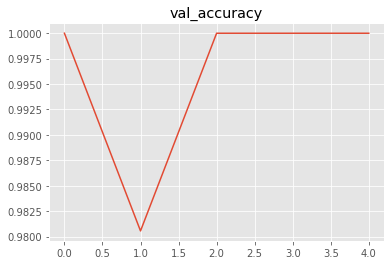

In [24]:
for i in model_history:
    plt.plot(model_history[i])
    plt.title(i)
    plt.show()

## Evaluate model

Generating predictions from validation data...


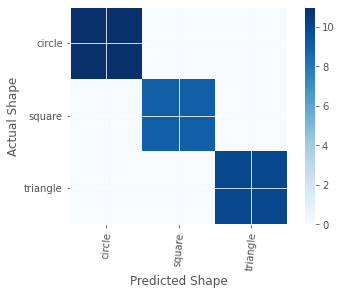

In [28]:
from sklearn.metrics import confusion_matrix

print("Generating predictions from validation data...")
# Get the image and label arrays for the first batch of validation data
x_test = testing_generator[0][0]
y_test = testing_generator[0][1]

# Use the model to predict the class
class_probabilities = model.predict(x_test)

# The model returns a probability value for each class
# The one with the highest probability is the predicted class
predictions = np.argmax(class_probabilities, axis=1)

# The actual labels are hot encoded (e.g. [0 1 0], so get the one with the value 1
true_labels = np.argmax(y_test, axis=1)

# Plot the confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=85)
plt.yticks(tick_marks, class_labels)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.show()